Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
rainfall = pd.read_csv('/content/rainfall.csv', index_col=['date'], parse_dates=['date'])

In [4]:
rainfall.head(10)

mean_rainfall
date                     
1990-01-01          1.613
1990-01-11          1.557
1990-01-21          2.219
1990-02-01          4.788
1990-02-11          6.510
1990-02-21          4.513
1990-03-01          6.793
1990-03-11          7.497
1990-03-21         13.219
1990-04-01         14.834

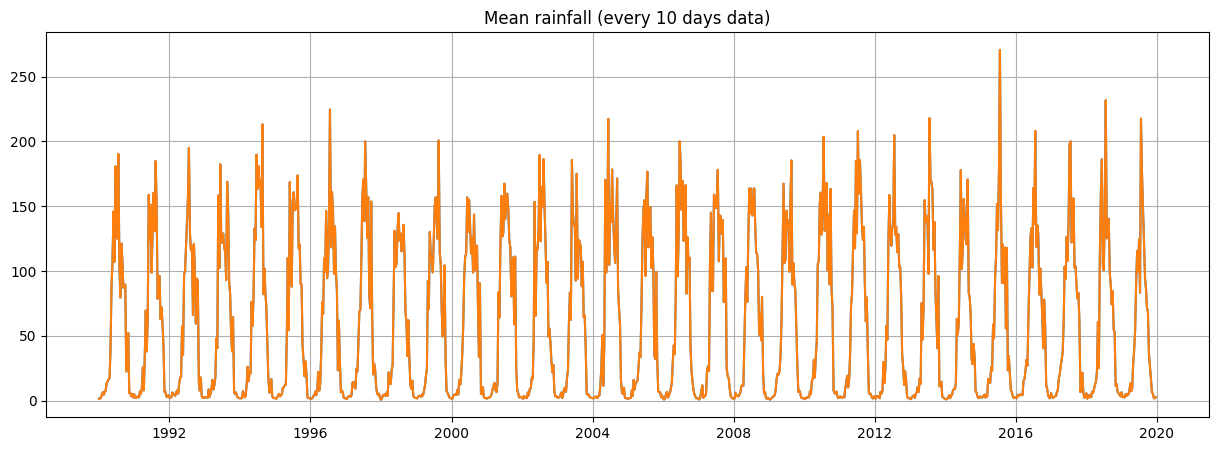

In [5]:
plt.figure(figsize=(15, 5))#Визуализация ряда и на основе его внешнего вида выполено предположения о его компонентах
plt.plot(rainfall.mean_rainfall)
plt.plot(rainfall.mean_rainfall)
plt.title('Mean rainfall (every 10 days data)')
plt.grid(True)
plt.show()

In [10]:
tr_size = 0.8
split_index = int(len(rainfall) * tr_size)

train = rainfall.iloc[:split_index]
test = rainfall.iloc[split_index:]

Бейзлайн

In [11]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(rainfall, 36) # Постронный бейзлайн в виде скользящего среднего

42.31666666666666

In [12]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    rolling_mean = series.rolling(window=window).mean()
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


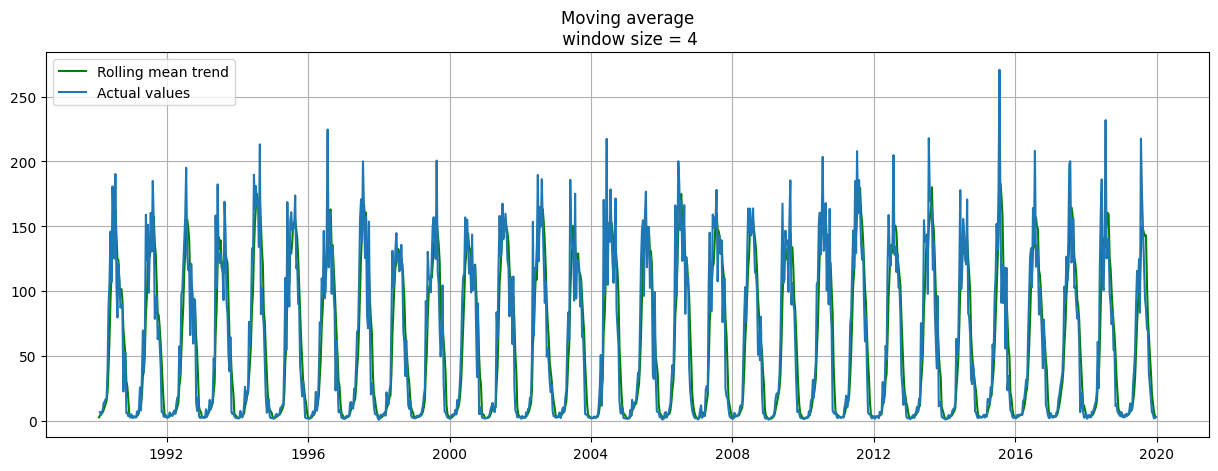

In [13]:
plotMovingAverage(rainfall, 4)

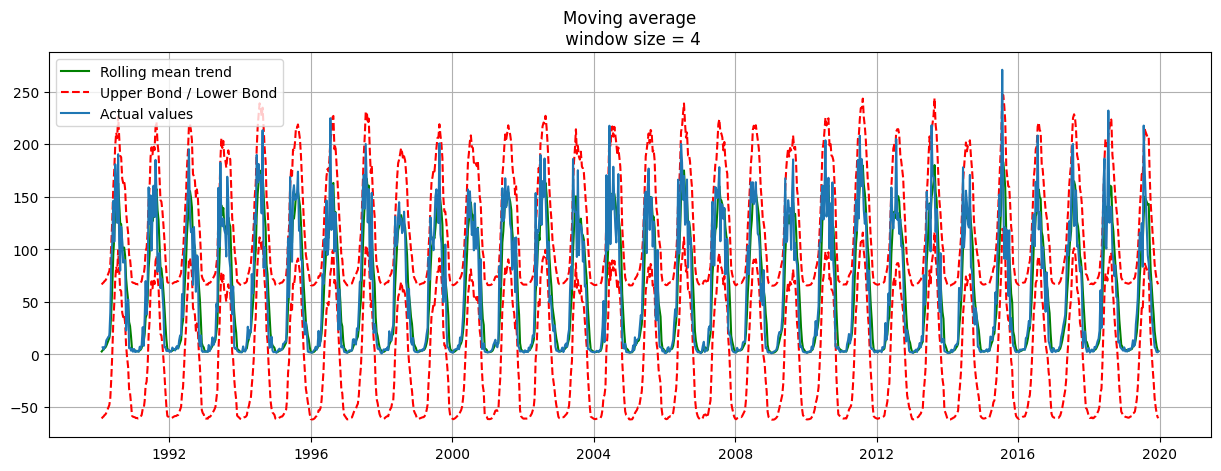

In [14]:
plotMovingAverage(rainfall, 4, plot_intervals=True)

In [16]:
rolling_mean = rainfall.rolling(window=4).mean()

MSE_metric = mean_squared_error(rainfall[4:], rolling_mean[4:])
print(f"Оценка скользящего среднего с использованием MSE метрики: {MSE_metric}")

Оценка скользящего среднего с использованием MSE метрики: 588.6012218296671


Статистическая модель

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        # Проверка теста Дики-Фуллера и интерпретация результатов
        # Построенные графики ACF/PACF

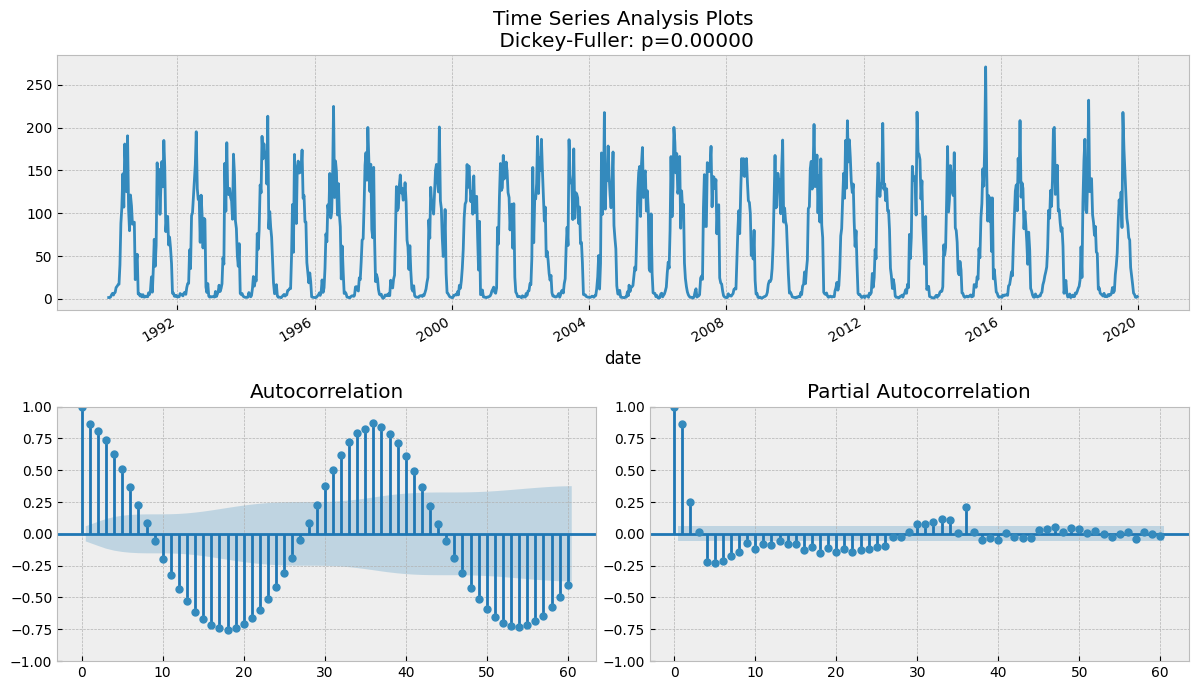

In [18]:
tsplot(rainfall.mean_rainfall, lags=60)

Согласно Тесту Дики — Фуллера p-value = 0.Следовательно ряд является  стационарным.

По графикам Автокорреляции/Частичной автокорреляции можно увидеть, что 36 лаг выделяется, а это принзак нестационарности.

Проводим сезонное дифференцирование с периодом 36.

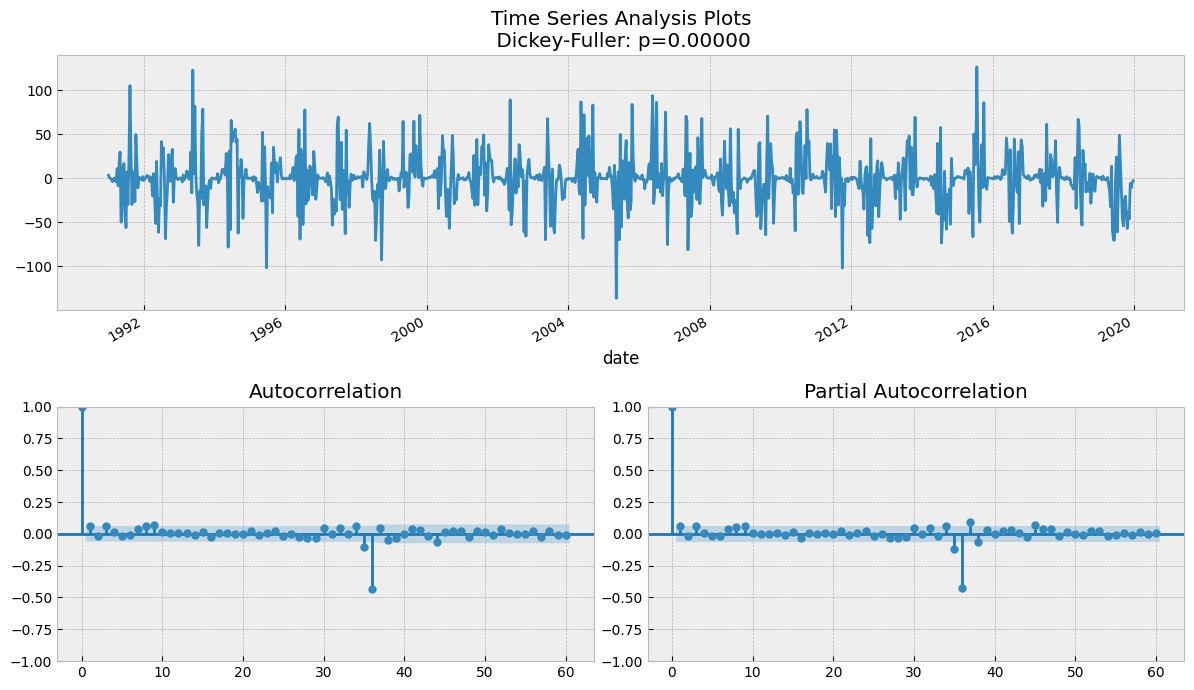

In [19]:
rainfall_diff = rainfall.mean_rainfall - rainfall.mean_rainfall.shift(36)
tsplot(rainfall_diff[36:], lags=60)

SARIMA

Подбор параметров

p = 1, поскольку это последнее значительное отставание PACF, после которого большинство других не являются значимыми.
d = 0, порядок дифференцирования
q = 1, потому что после 1 лага большинство других лагов становятся незначительными.
D= 1, один раз проводил сезонное дифференцирование
P и Q = 0 или 36, т.к. это единственные значимые лаги кратные 36.
S = 36, потому что период 36

In [20]:
arima_model=sm.tsa.statespace.SARIMAX(train, order=(1, 0, 1),
                                        seasonal_order=(0, 1, 0, 36))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
fit_arima_model = arima_model.fit()

<function matplotlib.pyplot.show(close=None, block=None)>

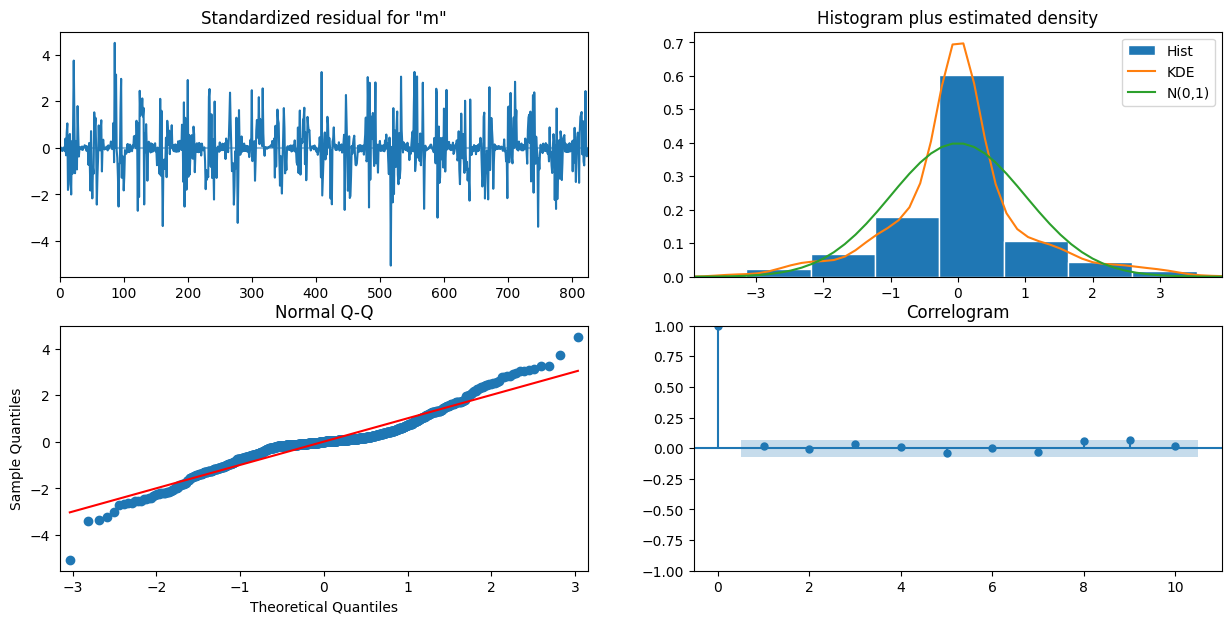

In [22]:
fit_arima_model.plot_diagnostics(figsize=(15,7))
plt.show


Остатки являются стационарными

In [23]:
predictions = fit_arima_model.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [24]:
from sklearn.metrics import mean_squared_error

# Считаем MSE
mse = mean_squared_error(test, predictions)
print(f'MSE =: {mse}')

MSE =: 782.0550240039388


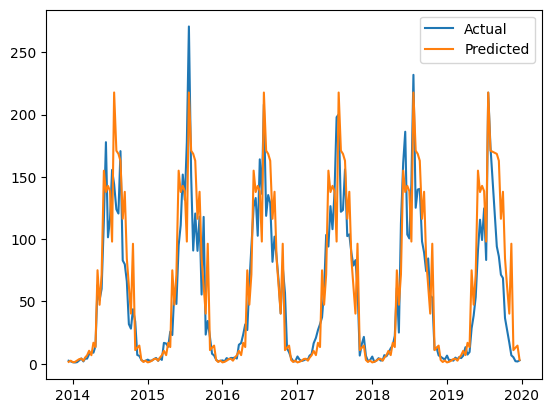

In [25]:
# Визуализация
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.legend()
plt.show()

Классическая модель

In [26]:
data = pd.DataFrame(rainfall.mean_rainfall.copy())
data.columns = ["y"]

for i in range(6, 37):
    data["lag_{}".format(i)] = data.y.shift(i)

In [27]:
data.index = pd.to_datetime(data.index)
data["year"] = data.index.year
data["month"] = data.index.month
data['rolling_mean'] = data['y'].rolling(window=4).mean()

In [28]:
data.tail(10)

y    lag_6    lag_7    lag_8    lag_9   lag_10   lag_11  \
date                                                                       
2019-09-21  71.462  124.734   99.326  115.623   90.929   53.567   38.641   
2019-10-01  68.751   83.297  124.734   99.326  115.623   90.929   53.567   
2019-10-11  36.663  217.653   83.297  124.734   99.326  115.623   90.929   
2019-10-21  27.367  174.259  217.653   83.297  124.734   99.326  115.623   
2019-11-01  16.856   94.172  174.259  217.653   83.297  124.734   99.326   
2019-11-11   6.737   86.126   94.172  174.259  217.653   83.297  124.734   
2019-11-21   5.216   71.462   86.126   94.172  174.259  217.653   83.297   
2019-12-01   2.022   68.751   71.462   86.126   94.172  174.259  217.653   
2019-12-11   1.780   36.663   68.751   71.462   86.126   94.172  174.259   
2019-12-21   2.694   27.367   36.663   68.751   71.462   86.126   94.172   

             lag_12   lag_13   lag_14  ...  lag_30  lag_31  lag_32  lag_33  \
date                                   ...                                   
2019-09-21   28.444    9.409    7.345  ...  11.245  53.160  54.645  84.529   
2019-10-01   38.641   28.444    9.409  ...  12.882  11.245  53.160  54.645   
2019-10-11   53.567   38.641   28.444  ...   6.700  12.882  11.245  53.160   
2019-10-21   90.929   53.567   38.641  ...   5.613   6.700  12.882  11.245   
2019-11-01  115.623   90.929   53.567  ...   4.382   5.613   6.700  12.882   
2019-11-11   99.326  115.623   90.929  ...   3.332   4.382   5.613   6.700   
2019-11-21  124.734   99.326  115.623  ...   6.501   3.332   4.382   5.613   
2019-12-01   83.297  124.734   99.326  ...   2.645   6.501   3.332   4.382   
2019-12-11  217.653   83.297  124.734  ...   3.084   2.645   6.501   3.332   
2019-12-21  174.259  217.653   83.297  ...   2.460   3.084   2.645   6.501   

            lag_34  lag_35  lag_36  year  month  rolling_mean  
date                                                           
2019-09-21  74.326  89.286  98.184  2019      9     106.50475  
2019-10-01  84.529  74.326  89.286  2019     10      80.12775  
2019-10-11  54.645  84.529  74.326  2019     10      65.75050  
2019-10-21  53.160  54.645  84.529  2019     10      51.06075  
2019-11-01  11.245  53.160  54.645  2019     11      37.40925  
2019-11-11  12.882  11.245  53.160  2019     11      21.90575  
2019-11-21   6.700  12.882  11.245  2019     11      14.04400  
2019-12-01   5.613   6.700  12.882  2019     12       7.70775  
2019-12-11   4.382   5.613   6.700  2019     12       3.93875  
2019-12-21   3.332   4.382   5.613  2019     12       2.92800  

[10 rows x 35 columns]

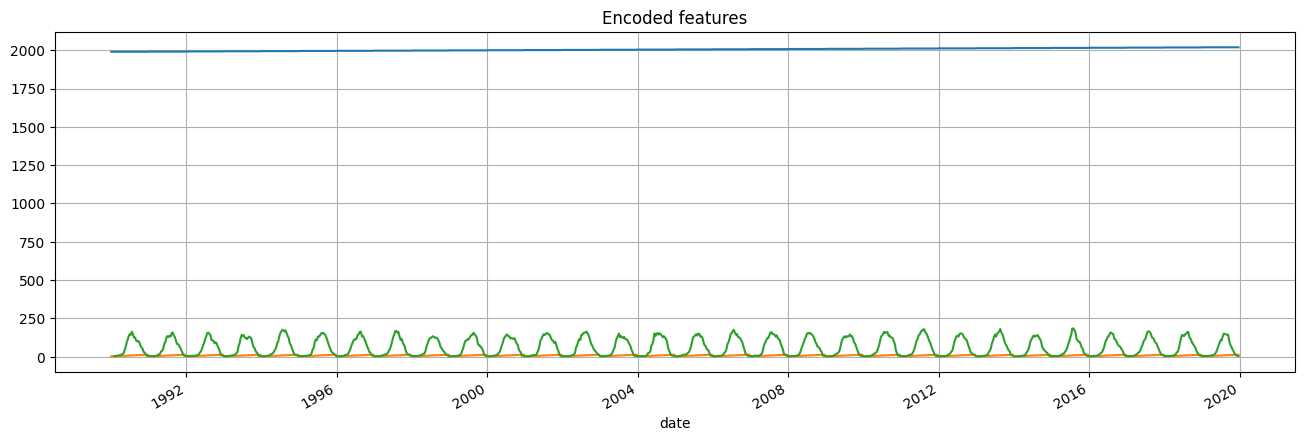

In [29]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.year.plot()
data.month.plot()
data.rolling_mean.plot()
plt.grid(True);

In [30]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """


    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [31]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)


X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [34]:
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [36]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                                    cv=tscv,
                                    scoring="neg_median_absolute_error")
        mse_met = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mse_met + scale * deviation)
        upper = prediction + (mse_met + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_squared_error(prediction, y_test)
    plt.title("MSE = {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

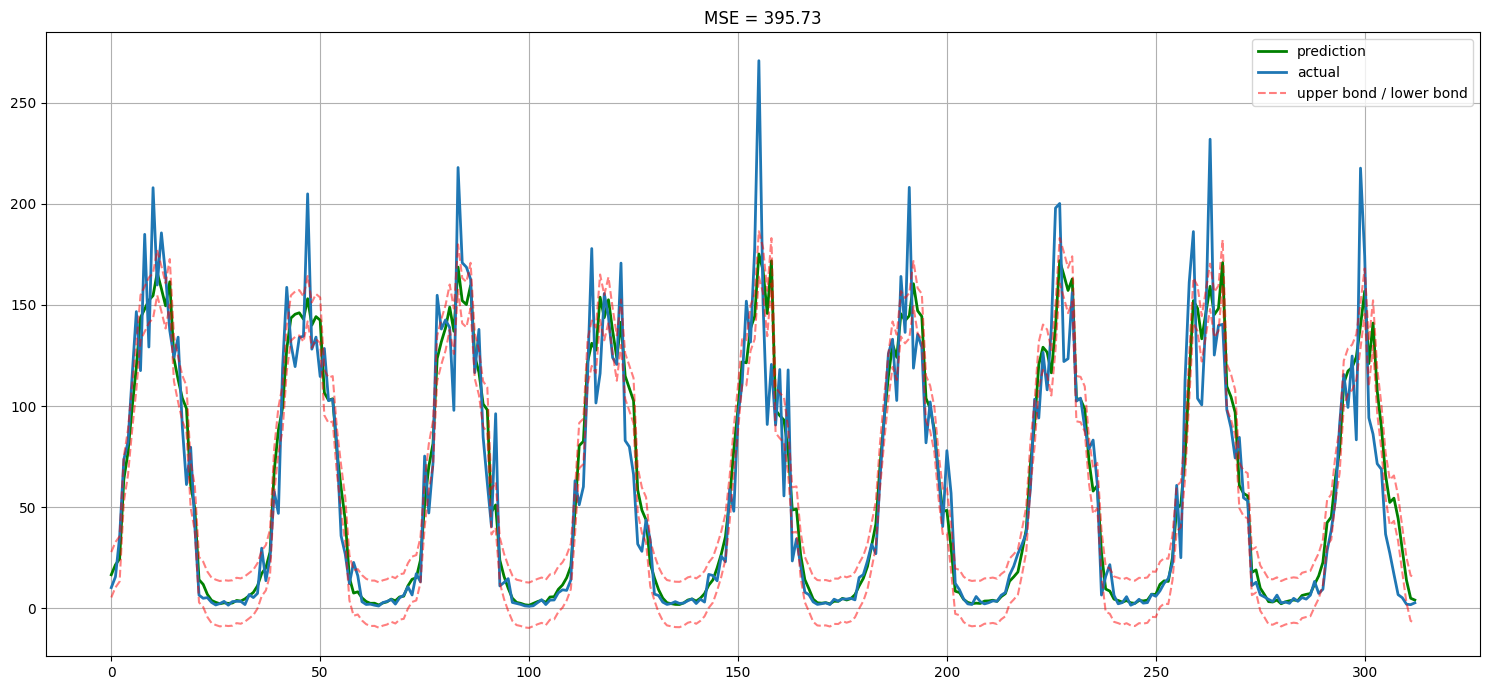

In [37]:
plotModelResults(rf, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)

Интерпретация

In [38]:
X_train_scaled1 = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns
)
X_test_scaled1 = pd.DataFrame(
    X_test_scaled,
    columns=X_test.columns
)

In [39]:
from sklearn.inspection import permutation_importance

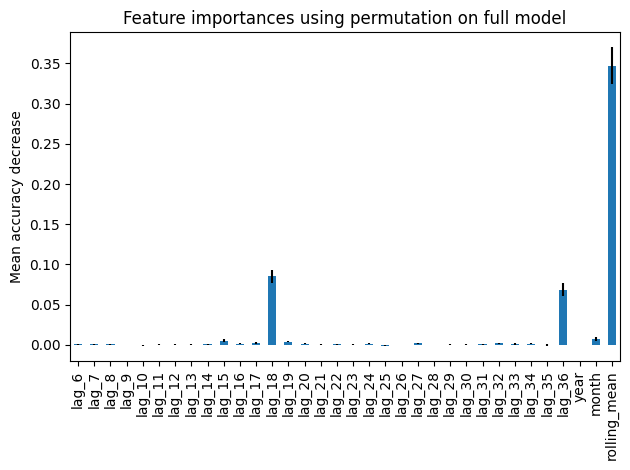

In [40]:
importances = permutation_importance(rf, X_test_scaled1, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [42]:
!pip install -U numpy==1.23.1 shap lime

import shap
from lime import lime_tabular

In [43]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train_scaled1.values,
    feature_names=X_train.columns,
    class_names=['y'],
    verbose=True,
    mode='regression',
)
i = 37
exp = explainer.explain_instance(X_test.iloc[i].values, rf.predict, num_features=5);

Intercept 49.75531564058908
Prediction_local [100.28997607]
Right: 115.18228


In [44]:
exp.show_in_notebook(show_table=True)

In [45]:
explainer = shap.TreeExplainer(rf)

In [46]:
choosen_instance = X_test_scaled1.loc[[100]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [47]:
choosen_instance = X_test_scaled1.loc[[4]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

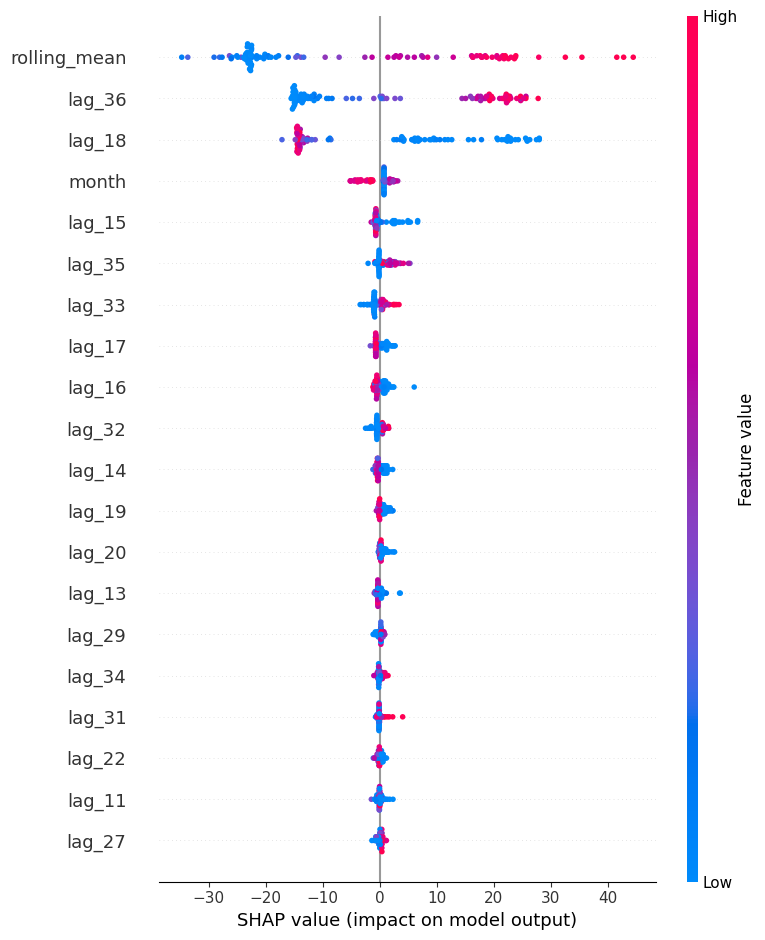

In [48]:
shap_values = explainer.shap_values(X_train_scaled1.iloc[:100])
shap.summary_plot(shap_values, X_train_scaled1.iloc[:100])